In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

# Урок 5. Кейс 1. Аномалии и артефакты.

**1. Прочитайте базу my_BRENT2019.csv**

In [27]:
data = pd.read_csv('./datasets/my_BRENT2019.csv', index_col=[0], parse_dates=[0]).sort_index()

data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         2667 non-null   float64
 1   year             2667 non-null   int64  
 2   month            2667 non-null   int64  
 3   dayofmonth       2667 non-null   int64  
 4   quarter          2667 non-null   int64  
 5   dayofyear        2667 non-null   int64  
 6   weekofyear       2667 non-null   int64  
 7   dayofweek        2667 non-null   int64  
 8   is_holiday       2667 non-null   int64  
 9   is_prev_holiday  2667 non-null   int64  
 10  is_next_holiday  2667 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


In [29]:
# Проверка индексов на дубли
data[data.index.duplicated(keep=False)].size

0

In [30]:
# Проверка на пропуски в индексах
pd.date_range('2010-09-01', '2019-09-01', freq="D").size == data.index.size

False

In [31]:
# Проверка на пропуски в данных
data[data['Значение'].isna()]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,


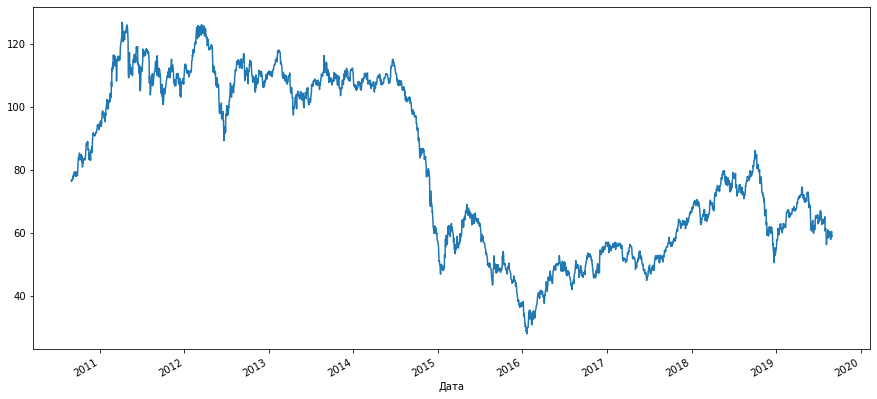

In [32]:
plt.figure( figsize=(15, 7))
data['Значение'].plot()
plt.show()

В данных имеются пропуски, но они пропадут после недельного ресэмплинга.

**2. Добавьте первые разности и стоимости доллара и евро к рублю (можно добавить их 1-е разности).**

In [57]:
usd = pd.read_excel('./datasets/usd_2010_2019.xlsx', index_col=[0], parse_dates=[0], usecols=[1,2]).rename(columns={ 'curs': 'usd' })
usd.head()

,usd
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [59]:
eur = pd.read_excel('./datasets/eur_2010_2019.xlsx', index_col=[0], parse_dates=[0], usecols=[1,2]).rename(columns={ 'curs': 'eur' })
eur.head()

,eur
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [66]:
data_with_data.merge(usd, how='left', left_index=True, right_index=True)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,usd
Дата,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,30.8669
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,30.8001
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,30.6858
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,30.6922
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0,65.9735
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0,66.2608
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0,66.4127


**3. Сделайте ее перрасчет (ресемплинг) в представление по неделям.**

In [23]:
data_week = data.resample('W').mean().sort_index()

data_week.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1
Дата,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.052000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,0.288333
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,-0.021667
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,0.118333
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,0.791667


In [18]:
# Проверка на пропуски в индексах
pd.date_range('2010-09-01', '2019-09-01', freq="W").size == data_week.index.size

True

Пропусков в данных нет.

In [46]:
data_week['diff1'] = data_week['Значение'].diff(1)

**4. Постройте модель предсказания 1-й точки от текущей (h=1).**

**5. Добавьте еще один любой экзогенный фактор.**

**6. Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.**